# **Creating the Machine Learning or Deep Learning Model**

Import packages - Will be focusing on the Pytorch implementation for further customizability in model architecture and training

In [137]:
# Pytorch
import torch                        # for all things Pytorch
import torch.nn as nn               # for torch.nn Module, the Parent object for Pytorch models
import torch.nn.functional as F     # for the activation function
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
print(f"Torch version: {torch.__version__}")
# Check CUDA availability
print(f"Is there CUDA available = {torch.cuda.is_available()}")
gpu_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Numpy
import numpy as np
print(f"NumPy version: {np.__version__}")

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
print(f"Matplotlib version: {mpl.__version__}")

# Pandas
import pandas as pd
print(f"Pandas version: {pd.__version__}")

# Scikit-Learn
import sklearn as sk
from sklearn.metrics import root_mean_squared_error, r2_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Lasso
print(f"Scikit-learn version: {sk.__version__}")

from xgboost import XGBRegressor

import joblib


Torch version: 2.4.1+cu118
Is there CUDA available = True
NumPy version: 1.26.4
Matplotlib version: 3.9.2
Pandas version: 2.2.3
Scikit-learn version: 1.5.2


Load in Data

In [2]:
data = pd.read_csv("SeoulBikeData.csv", encoding='ISO-8859-1')
print(f"Dataframe Columns: {data.columns.values}")
data.head(2)

Dataframe Columns: ['Date' 'Rented Bike Count' 'Hour' 'Temperature(C)' 'Humidity(%)'
 'Wind speed (m/s)' 'Visibility (10m)' 'Dew point temperature(ï¿½C)'
 'Solar Radiation (MJ/m2)' 'Rainfall(mm)' 'Snowfall (cm)' 'Seasons'
 'Holiday' 'Functioning Day']


,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(ï¿½C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes


# Model Creation
Goal: Create a Model that is able to predict the total number of bike rentals in Seoul given 24 hours, which results in 24 different predictions where we kinda model the curve that reprsents Rentals per hour.
Additionally, we might consider an LSTM network to consider past hour rentals. Additionally, we have to answer the question if the data is dependent on previous hours or not.

Additional Models:
- One model for predicting the amount of bikes for a specific HOUR
- One model for predicting the amount of bikes for a specific DAY


Considerations:

- *LSTM Network possibly* ------ MAIN GOAL for us to predict the curve of bike rentals from a week of data beforehand
- Deep Regression Netowrk(MLP) for Regression
- Linear Regression ML Model

Most Important Features Ranked 1(Most Important) - 3(Least Important): These are Assumptions
- Rented Bike Count (TARGET VARIABLE)
- Hour                      1
- Temperature               1
- Humidity                  2
- Wind Speed                3
- Visibility                3
- Dew Point Temperature     1
- Solar Radiation           1
- Rainfall                  1
- Snowfall                  1
- Seasons                   3
- Holiday                   3
- Functioning Day           2

# Preprocess and set-up data

One Hot encoding the seasons, and binary encoding the holiday and functional day

# *THE HOURLY BASED DATAFRAME*

In [3]:
########## RUN ONLY ONCE ######################

# One-hot encode column 'SEASON'
one_hot_encoded = pd.get_dummies(data['Seasons'], prefix='Season', drop_first=False)
print(data['Seasons'].unique())
# Concatenate the original DataFrame with the one-hot encoded columns of SEASONS
data = pd.concat([data, one_hot_encoded], axis=1)

# Binary encoding of the Functioning day YES or NO
data['Functioning Day'] = (data['Functioning Day'] == 'Yes').astype(int)

# Binary encoding of the Holiday day NO HOLIDAY or HOLIDAY
data['Holiday'] = (data['Holiday'] == 'No Holiday').astype(int)

['Winter' 'Spring' 'Summer' 'Autumn']


Try to normalize the Temperatures, so values are >= 0

In [4]:
# THE MINIMUM DEW POINT TEMP
min = np.min(data['Dew point temperature(ï¿½C)'].values) 

# SCALING THE MAX value with Min value absolute value, so we can see if we can push all variables to being positive
max = np.max(data['Dew point temperature(ï¿½C)'].values) + np.abs(min)

print(f"Unscaled Min: {min}")
print(f"Scaled Max: {max}")

#data['Dew point temperature(ï¿½C)'] = 

Unscaled Min: -30.6
Scaled Max: 57.8


In [5]:
# COLUMNS TO CONVERT TO BINARY: 0 or 1
bool_cols = ['Season_Autumn', 'Season_Spring','Season_Summer', 'Season_Winter']

# Actually changing to Binary
data[bool_cols] = data[bool_cols].astype(int)

data.head(2)

,Date,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(ï¿½C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day,Season_Autumn,Season_Spring,Season_Summer,Season_Winter
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,1,1,0,0,0,1
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,1,1,0,0,0,1


In [6]:
data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
data['Month'] = data['Date'].dt.month
data['Day'] = data['Date'].dt.day
data['Year'] = data['Date'].dt.year
print(f"Data Columns {data.columns}")

Data Columns Index(['Date', 'Rented Bike Count', 'Hour', 'Temperature(C)', 'Humidity(%)',
       'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(ï¿½C)',
       'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons',
       'Holiday', 'Functioning Day', 'Season_Autumn', 'Season_Spring',
       'Season_Summer', 'Season_Winter', 'Month', 'Day', 'Year'],
      dtype='object')


Create Features and Target units

In [7]:
X_hourly = data.drop(columns=['Rented Bike Count', 'Date', 'Seasons', 'Year'])
y_hourly = data['Rented Bike Count']

# *THE DAILY BASED DATAFRAME*

In [8]:
# Min-max scaling function
def min_max_scaling(series):
    return (series - series.min()) / (series.max() - series.min())

In [10]:
# Create a new DataFrame for daily aggregation
daily = data.groupby(['Year', 'Month', 'Day']).agg(
    Rented_Bike_Count=('Rented Bike Count', 'sum'),
    Temperature_C=('Temperature(C)', 'mean'),
    Humidity_percent=('Humidity(%)', 'mean'),
    Wind_speed_m_s=('Wind speed (m/s)', 'mean'),
    Visibility_10m=('Visibility (10m)', 'mean'),
    Dew_point_temperature_C=('Dew point temperature(ï¿½C)', 'mean'),
    Solar_Radiation_MJ_m2=('Solar Radiation (MJ/m2)', 'mean'),
    Rainfall_mm=('Rainfall(mm)', 'mean'),
    Snowfall_cm=('Snowfall (cm)', 'mean'),
    Seasons=('Seasons', 'first'),  # Assuming seasons are consistent for the day
    Holiday=('Holiday', 'first'),  # Assuming holiday status is consistent for the day
    Functioning_Day=('Functioning Day', 'first'),  # Same for functioning day
    Season_Autumn=('Season_Autumn', 'mean'),  # Mean for one-hot encoded columns
    Season_Spring=('Season_Spring', 'mean'),
    Season_Summer=('Season_Summer', 'mean'),
    Season_Winter=('Season_Winter', 'mean')
).reset_index()

# Convert Temperatures to Farenheit

daily['Temperature_C'] = (daily['Temperature_C'] * (9/5)) + 32
daily['Dew_point_temperature_C'] = (daily['Dew_point_temperature_C'] * (9/5)) + 32

# Apply min-max scaling to the columns
daily['Visibility_10m_Scaled'] = min_max_scaling(daily['Visibility_10m'])
daily['Temperature_C_Scaled'] = min_max_scaling(daily['Temperature_C'])
daily['Humidity_percent_Scaled'] = min_max_scaling(daily['Humidity_percent'])
daily['Wind_speed_m_s_Scaled'] = min_max_scaling(daily['Wind_speed_m_s'])

daily['Rented_Bike_LogScale'] = np.log(daily['Rented_Bike_Count'] + 1)

daily.columns

Index(['Year', 'Month', 'Day', 'Rented_Bike_Count', 'Temperature_C',
       'Humidity_percent', 'Wind_speed_m_s', 'Visibility_10m',
       'Dew_point_temperature_C', 'Solar_Radiation_MJ_m2', 'Rainfall_mm',
       'Snowfall_cm', 'Seasons', 'Holiday', 'Functioning_Day', 'Season_Autumn',
       'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Visibility_10m_Scaled', 'Temperature_C_Scaled',
       'Humidity_percent_Scaled', 'Wind_speed_m_s_Scaled',
       'Rented_Bike_LogScale'],
      dtype='object')

In [11]:
daily.to_csv("dailyData.csv")

In [57]:
X_daily = daily.drop(columns=['Rented_Bike_Count', 'Seasons', 'Year', 'Visibility_10m', 'Temperature_C', 'Humidity_percent', 'Wind_speed_m_s', 'Rented_Bike_LogScale'])
print(f"Feature number: {X_daily.columns}")
y_daily = daily['Rented_Bike_LogScale']


Feature number: Index(['Month', 'Day', 'Dew_point_temperature_C', 'Solar_Radiation_MJ_m2',
       'Rainfall_mm', 'Snowfall_cm', 'Holiday', 'Functioning_Day',
       'Season_Autumn', 'Season_Spring', 'Season_Summer', 'Season_Winter',
       'Visibility_10m_Scaled', 'Temperature_C_Scaled',
       'Humidity_percent_Scaled', 'Wind_speed_m_s_Scaled'],
      dtype='object')


Setting up Threshold Value

Create Dataset Loader Class

In [74]:
class BikeRentalData(Dataset):
    def __init__(self, features, targets):
        self.features = torch.tensor(features.values, dtype=torch.float32)
        self.targets = torch.tensor(targets.values, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

Hourly Datasets

In [235]:
# Create Dataset and DataLoader
dataset_hourly = BikeRentalData(X_hourly, y_hourly)

# Define split sizes
train_size = int(0.7 * len(dataset_hourly))  # 70% for training
valid_size = int(0.15 * len(dataset_hourly))  # 15% for validation
test_size = len(dataset_hourly) - train_size - valid_size  # 15% for testing

# Split the dataset
train_dataset, valid_dataset, test_dataset = random_split(dataset_hourly, [train_size, valid_size, test_size])

# Create DataLoaders for each dataset
train_loader_hourly = DataLoader(train_dataset, batch_size=30, shuffle=True)
valid_loader_hourly = DataLoader(valid_dataset, batch_size=30, shuffle=False) # Want consistent results, not random
test_loader_hourly = DataLoader(test_dataset, batch_size=30, shuffle=False) # Want consistent results, not random

Daily Datasets

In [236]:
# Create Dataset and DataLoader
dataset_daily = BikeRentalData(X_daily, y_daily)

# Define split sizes
train_size = int(0.7 * len(dataset_daily))  # 70% for training
valid_size = int(0.15 * len(dataset_daily))  # 15% for validation
test_size = len(dataset_daily) - train_size - valid_size  # 15% for testing

# Split the dataset
train_dataset, valid_dataset, test_dataset = random_split(dataset_daily, [train_size, valid_size, test_size])

# Create DataLoaders for each dataset
train_loader_daily = DataLoader(train_dataset, batch_size=3, shuffle=True)
valid_loader_daily = DataLoader(valid_dataset, batch_size=3, shuffle=False) # Want consistent results, not random
test_loader_daily = DataLoader(test_dataset, batch_size=3, shuffle=False) # Want consistent results, not random

Create Training Loop

In [274]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=35, device='cuda'):
    trainLossValues = []
    model.to(device)  # Move model to the specified device
    # FOR MODEL TRAINING
    model.train()  # Set the model to training mode

    for epoch in range(num_epochs): # Epoch training

        running_loss = 0.0
        for inputs, targets in dataloader:

            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device

            # Zero the gradients and prevent accumulation of gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Accumulate loss
            running_loss += loss.item()
        
        # Store the average loss per batch into a list
        trainLossValues.append(running_loss/len(dataloader))
        # Print average loss for this epoch
        print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(dataloader):.4f}")
        
    print(f"Size of Training Set: {len(trainLossValues)}")
    return trainLossValues
    
# Validation (optional)
def validate_model(model, dataloader, criterion, device='cuda'):
    model.eval()  # Set the model to evaluation mode

    total_loss = 0.0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)  # Move data to the specified device
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    print(f"Length of Validation Data: {len(dataloader)}")
    print(f'Validation Loss: {total_loss / len(dataloader):.4f}')

# Testing (optional)
def test_model(model, dataloader, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    all_outputs = []  # List to store outputs
    all_targets = []  # List to store targets

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)  # Move data to the specified device
            outputs = model(inputs)

            # Store outputs and targets
            all_outputs.append(outputs.cpu())  # Move outputs to CPU and append
            all_targets.append(targets.cpu())  # Move targets to CPU and append

            #print(f'Inputs: {inputs.cpu().numpy()}, Predicted: {outputs.cpu().numpy()}, Targets: {targets.cpu().numpy()}')

    # Concatenate all outputs and targets
    all_outputs = torch.cat(all_outputs).numpy()  # Convert to NumPy array
    all_targets = torch.cat(all_targets).numpy()  # Convert to NumPy array

    all_outputs_reverted = np.exp(all_outputs) - 1
    all_targets_reverted = np.exp(all_targets) - 1
    
    mse_loss_pytorch = mean_absolute_error(all_outputs_reverted, all_targets_reverted)

    # Here you can add code to evaluate your model's predictions
    print(f"Output Values from Test Data: {[i for i in all_outputs][0:5]}")
    print(f"Output Values from Actual Data: {[i for i in all_targets][0:5]}")
    print(f"Accuracy: {mse_loss_pytorch} for daily loss of rescaled values")



# *Deep Neural Network Regression Model Architecture*


Flow:

    - Train on many hours worth of data(Amount of bike rentals) given inputs like hour

    - Test how regression works when given a certain hour

In [276]:
BATC_SIZEH_SIZE = 16
DIM_IN = 16
DIM_OUT = 1

class RentalDNNRegression(nn.Module):
    
    def __init__(self):
        super(RentalDNNRegression, self).__init__()
        # Creating Layers

        # First Layer
        self.lin1 = nn.Linear(DIM_IN, 512)
        self.batch1 = nn.BatchNorm1d(512)
        #self.drop1 = nn.Dropout(0.45)

        # Second Layer
        self.lin2 = nn.Linear(512, 256)
        self.batch2 = nn.BatchNorm1d(256)
        #self.drop2 = nn.Dropout(0.25)


        # Third Layer
        self.lin3 = nn.Linear(256, 256)
        self.batch3 = nn.BatchNorm1d(256)
        #self.drop3 = nn.Dropout(0.25)

        # Fourth Layer
        self.lin4 = nn.Linear(256, 128)
        self.batch4 = nn.BatchNorm1d(128)
        #self.drop4 = nn.Dropout(0.2)

        # Fifth Layer
        self.lin5 = nn.Linear(128, 64)
        self.batch5 = nn.BatchNorm1d(64)
        #self.drop5 = nn.Dropout(0.2)

        # Sixth Layer
        self.lin6 = nn.Linear(64, 16)
        self.batch6 = nn.BatchNorm1d(16)

        # Output Layer
        self.out = nn.Linear(16, DIM_OUT)
        
    def forward(self, x):
        # Apply Batch Normalization
        #x = self.batch1(x)  # Apply batch normalization
        x = F.relu(self.lin1(x))
        x = self.batch1(x)
        #x = self.drop1(x)

        x = F.relu(self.lin2(x))
        x = self.batch2(x)
        #x = self.drop2(x)

        x = F.relu(self.lin3(x))
        x = self.batch3(x)
        #x = self.drop3(x)

        x = F.relu(self.lin4(x))
        x = self.batch4(x)
        #x = self.drop4(x)

        x = F.relu(self.lin5(x))
        x = self.batch5(x)
        #x = self.drop5(x)

        x = F.relu(self.lin6(x))
        x = self.batch6(x)

        x = self.out(x) # Call the final layer

        return x
    
# Instantiating Model "object"
rentalMLPReg = RentalDNNRegression()

# Moving model to GPU memory if available
gpu_device = 'cuda' if torch.cuda.is_available() else 'cpu'
rentalMLPReg.to(gpu_device)

# Loss Function Criterion
criterion = nn.MSELoss()

# Optimizer Instantiatio6
optimizer = optim.Adadelta(params=rentalMLPReg.parameters(), lr=0.0275)

print(rentalMLPReg)

RentalDNNRegression(
  (lin1): Linear(in_features=16, out_features=512, bias=True)
  (batch1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=512, out_features=256, bias=True)
  (batch2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin3): Linear(in_features=256, out_features=256, bias=True)
  (batch3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin4): Linear(in_features=256, out_features=128, bias=True)
  (batch4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin5): Linear(in_features=128, out_features=64, bias=True)
  (batch5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin6): Linear(in_features=64, out_features=16, bias=True)
  (batch6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (out): Linear(in_features=16, out_features=1, b

Train the Model??

In [277]:
trainLossValuesDaily = train_model(rentalMLPReg, train_loader_daily, criterion, optimizer, num_epochs=90, device=gpu_device)

Epoch [1/90], Loss: 86.1681
Epoch [2/90], Loss: 85.6691
Epoch [3/90], Loss: 84.9934
Epoch [4/90], Loss: 84.1364
Epoch [5/90], Loss: 83.2610
Epoch [6/90], Loss: 82.1308
Epoch [7/90], Loss: 80.9110
Epoch [8/90], Loss: 79.2984
Epoch [9/90], Loss: 77.6303
Epoch [10/90], Loss: 75.2295
Epoch [11/90], Loss: 72.5694
Epoch [12/90], Loss: 69.2971
Epoch [13/90], Loss: 65.3442
Epoch [14/90], Loss: 60.8617
Epoch [15/90], Loss: 55.6713
Epoch [16/90], Loss: 49.9834
Epoch [17/90], Loss: 43.9158
Epoch [18/90], Loss: 37.6861
Epoch [19/90], Loss: 31.9051
Epoch [20/90], Loss: 26.5683
Epoch [21/90], Loss: 21.6269
Epoch [22/90], Loss: 17.4985
Epoch [23/90], Loss: 14.3220
Epoch [24/90], Loss: 11.7261
Epoch [25/90], Loss: 9.9787
Epoch [26/90], Loss: 8.4485
Epoch [27/90], Loss: 7.6277
Epoch [28/90], Loss: 6.8774
Epoch [29/90], Loss: 6.0533
Epoch [30/90], Loss: 5.6817
Epoch [31/90], Loss: 5.3226
Epoch [32/90], Loss: 5.1169
Epoch [33/90], Loss: 4.9048
Epoch [34/90], Loss: 5.0238
Epoch [35/90], Loss: 4.5972
Epoch

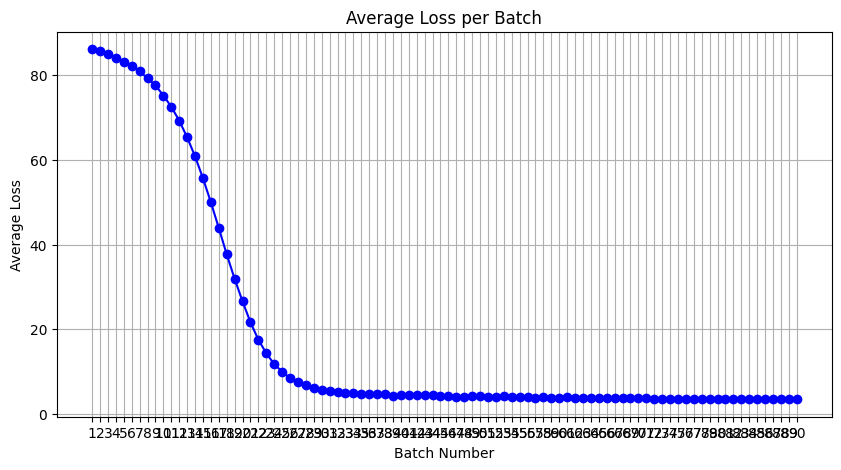

In [280]:
# Plotting out Training Loss

batch_indices = np.arange(1, len(trainLossValuesDaily) + 1)

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(batch_indices, trainLossValuesDaily, marker='o', linestyle='-', color='b')
plt.title('Average Loss per Batch')
plt.xlabel('Batch Number')
plt.ylabel('Average Loss')
plt.grid()
plt.xticks(batch_indices)  # Optional: Show all batch numbers on the x-axis
plt.show()

This isn't really model convergence because it looks like the model is getting a steep drop-off in loss, and then begins to oscillate.

In [281]:
test_model(rentalMLPReg, test_loader_daily, device=gpu_device)
validate_model(rentalMLPReg, valid_loader_daily, criterion, device=gpu_device)


Output Values from Test Data: [array([9.4211855], dtype=float32), array([9.225501], dtype=float32), array([8.666949], dtype=float32), array([8.015822], dtype=float32), array([8.917966], dtype=float32)]
Output Values from Actual Data: [10.140692, 10.395222, 10.233546, 9.408535, 8.950663]
Accuracy: 11116.4521484375 for daily loss of rescaled values
Length of Validation Data: 18
Validation Loss: 6.3940


c:\Users\lordw\OneDrive\Documents\Python_Master\Coding_Projects\BikingAnalytics\venv\Lib\site-packages\torch\nn\modules\loss.py:538: UserWarning: Using a target size (torch.Size([3])) that is different to the input size (torch.Size([3, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


# *Scikit-Learn Regression Model Architectures*

Splitting Data into test train sets

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X_daily, y_daily, test_size=0.2)

Lasso ML Model

In [105]:
lasso = Lasso()

lasso.fit(X_train, y_train)

y_pred_lasso = lasso.predict(X_test)

matchingAvgLasso = np.mean(np.abs(y_pred_lasso - y_test) <= 0.7)

print(f"Average accuracy with a threshold value for LASSO REGRESSION: {matchingAvgLasso}")
print("Did better than Pytorch model")

Average accuracy with a threshold value for LASSO REGRESSION: 0.589041095890411
Did better than Pytorch model


Time to Cross Validate Linear Regression, Decision Tree Regessor, Random Forest Regressor models.

In [106]:
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42)
}

In [109]:
results = {}
for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    results[name] = -scores.mean()  # Negate to get MSE

results_df = pd.DataFrame(results, index=['Mean Squared Error'])
print(results_df)

                    Linear Regression  Random Forest  Decision Tree
Mean Squared Error           0.556378       0.390847       0.453427


We understand that generally the best model is Linear Regression followed by Decision Tree and then Random Forest

Model: Linear Regression
Recovered y_test: [6227.000000000002, 18956.000000000004, 15277.0, 27673.99999999999, 11158.999999999993, 14434.999999999987, 9539.000000000005, 5847.999999999997, 31927.99999999998, 13084.0, 31680.999999999975, 8968.000000000007, 6477.000000000002, 5200.000000000001, 3359.999999999999, 31235.99999999998, 3932.000000000002, 6665.999999999997, 9184.000000000005, 13376.999999999996, 26504.000000000015, 1720.9999999999998, 7448.0000000000055, 20641.00000000001, 28078.999999999978, 16282.000000000015, 25913.000000000022, 0.0, 14318.999999999993, 2828.0000000000014, 4697.000000000001, 29812.999999999993, 24076.999999999985, 35103.00000000001, 24134.999999999978, 19180.00000000001, 22826.999999999996, 28820.00000000001, 6770.999999999996, 31075.999999999978, 22896.999999999985, 29754.999999999975, 9608.999999999995, 2931.0, 4110.999999999999, 16086.999999999993, 7711.000000000002, 7198.000000000005, 28477.99999999998, 6624.000000000001]
Recovered y_pred: [7084.011824

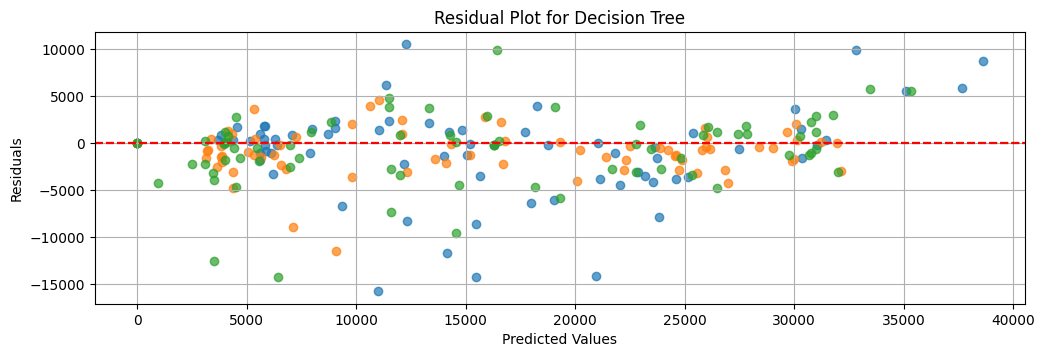

In [160]:
results = {}
plt.figure(figsize=(12, len(models) * 4))  # Create a figure with a specified size

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    results[name] = mse  # Store MSE for predictions on the test set

    # Convert back to original scale (if needed for other calculations)
    recovered_y_test = np.exp(y_test) - 1
    recovered_y_pred = np.exp(y_pred) - 1
    
    # Calculate mean squared error on the original predictions
    reverted_mae = mean_absolute_error(recovered_y_pred, recovered_y_test)
    reverted_rmse = root_mean_squared_error(recovered_y_pred, recovered_y_test)
    reverted_mse = mean_squared_error(recovered_y_pred, recovered_y_test)

    # Store MSE for predictions on the test set
    results[name] = mse  # Store MSE
    
    # Display the original and recovered values for inspection (optional)
    print(f"Model: {name}")
    print("Recovered y_test:", [i for i in recovered_y_test][0:50])
    print("Recovered y_pred:", [j for j in recovered_y_pred][0:50])
    print("Mean Absolute Error:", reverted_mae)
    print(f"If I take the test set and divide by data length I get the average MAE loss per DAY, which is: {reverted_mae}")
    print(f"If I take the test set and divide by data length I get the average RMSE loss per DAY, which is: {reverted_rmse}")
    print(f"If I take the test set and divide by data length I get the average MSE loss per DAY, which is: {reverted_mse}")


    # Save the model
    joblib.dump(model, f'{name}_model.joblib')  # Save the model to a file


    plt.subplot(len(models), 1,  + 1)  # Create a subplot for each model
    plt.scatter(recovered_y_pred, recovered_y_pred - recovered_y_test, alpha=0.7)
    plt.axhline(y=0, color='r', linestyle='--')  # Add a horizontal line at 0
    plt.title(f'Residual Plot for {name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.grid()



Really good predictions because I took a hourly dataset and got to a average of 

XGBoost Model

In [161]:
model = XGBRegressor(
    n_estimators=2000,
    learning_rate=0.1,
    n_jobs=4,
    seed=34
)

model.fit(
    X_train,
    y_train,  
    verbose=False,
)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=4,
             num_parallel_tree=None, random_state=None, ...)

Can't capture the complexities of the features obviously as many factors can cause shift in bike demand such as previous hour's bike demand.

In [162]:
y_pred = model.predict(X_test)
# Calculate metrics

# Convert back to original scale (if needed for other calculations)
recovered_y_test = np.exp(y_test) - 1
xg_ypred_reverted = np.exp(y_pred) - 1

rmse = mean_absolute_error(xg_ypred_reverted, y_pred)  # RMSE
print([i for i in recovered_y_test])
print([j for j in recovered_y_pred])
print("Root Mean Squared Error:", rmse)

[6227.000000000002, 18956.000000000004, 15277.0, 27673.99999999999, 11158.999999999993, 14434.999999999987, 9539.000000000005, 5847.999999999997, 31927.99999999998, 13084.0, 31680.999999999975, 8968.000000000007, 6477.000000000002, 5200.000000000001, 3359.999999999999, 31235.99999999998, 3932.000000000002, 6665.999999999997, 9184.000000000005, 13376.999999999996, 26504.000000000015, 1720.9999999999998, 7448.0000000000055, 20641.00000000001, 28078.999999999978, 16282.000000000015, 25913.000000000022, 0.0, 14318.999999999993, 2828.0000000000014, 4697.000000000001, 29812.999999999993, 24076.999999999985, 35103.00000000001, 24134.999999999978, 19180.00000000001, 22826.999999999996, 28820.00000000001, 6770.999999999996, 31075.999999999978, 22896.999999999985, 29754.999999999975, 9608.999999999995, 2931.0, 4110.999999999999, 16086.999999999993, 7711.000000000002, 7198.000000000005, 28477.99999999998, 6624.000000000001, 16496.000000000007, 26398.00000000002, 21002.999999999985, 25355.00000000